In [1]:
# Import all libraries and packages

import pandas as pd
import numpy as np
import math
import json


from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler
import seaborn as sns #For Data visualization
import matplotlib.pyplot as plt #Data plotting and visualization
sns.set_palette(sns.color_palette('Set2'))
import plotly.express as px
%matplotlib inline


from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.cluster import KMeans

In [2]:
# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
#Import functions with clean data
from clean_data import clean_portfolio, clean_profile, clean_transcript

#Cleaned Portfolio data
portfolio_df = clean_portfolio(portfolio)

#profile_da - Demographic data, profile_m: Demographic data with encoding
profile_da, profile_m = clean_profile(profile)

#offers- Offer data, transactions -Transaction dataframe
offers,transactions = clean_transcript(transcript)


In [4]:
portfolio_df.head(3)

,offer_id,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,offer_1,bogo,10,7,10,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_2,bogo,10,5,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,offer_3,informational,0,4,0,1,1,0,1


In [5]:
#Profile Data
profile_da.head(3)

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,membership_year
0,0610b486422d4921ae7d2bf64640c50b,F,55,GenXers(44-56),112000.0,$100K,2017-07-15,2017
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,Boomers(57-75),100000.0,$100K,2017-05-09,2017
2,e2127556f4f64592b11af22de27a7932,M,68,Boomers(57-75),70000.0,"$50,000 - $74,999",2018-04-26,2018


In [6]:
#Profile data wth encoding
profile_m.head(3)

,customer_id,F,M,O,GenZ(18–25),Millennias(26-43),GenXers(44-56),Boomers(57-75),Matures(76+),"$50,000 - $74,999","$75,000 - $99,999",$100K,2013,2014,2015,2016,2017,2018
0,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1


In [7]:
#Offers data
offers.head(3)

,customer_id,event,time_in_days,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,1,0


In [8]:
#Transaction data
transactions.head(3)

,customer_id,event,time_in_days,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23


## Feature Engineering

In this section, we are going to create a dataFrame with features aggregated to each customer IDs along with all demographic detailes of individual customers. 

The objective if to create a DataFrame such that its easier to aggregarte data for data analysis and visualization. 

1. We will be creating the following features for each of the offer type,offer reward, offer duration, offer difficulty, channels etc. 

* Offer recieved count
* Offer Viewed count/viewed rate
* Offer complted count/completed rate

2. Crete new fatures based on customer segmentation. eg RFM or cluster analysis. 

In [9]:
#Merge Offer data and portfolio dataframe
offers_portfolio = pd.merge(offers, portfolio_df, left_on='offer_id', right_on='offer_id', how='inner')

In [10]:
offers_portfolio.head(3)

,customer_id,event,time_in_days,offer_id,completed,received,viewed,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1


In [11]:

def offer_success(offers_portfolio, column):
    
    """
    This procedure is to create the following features:
    
    -Offer recieved count
    -Offer Viewed count/viewed rate
    -Offer complted count/completed rate
    
    For each of Offer type, Offer name, offer difficulty, offer durtion, offer reward
    
    INPUT: 
    - offers_portfolio: Offer_portfolio dataframe
    - column: column name for which the feature must be created. ed - offer_type, offer_name
    
    OUTPUT:
    - all_res: A list of dataframe
    
    """

    offer_name = offers_portfolio[column].unique()

    all_res = []
    for offer in offer_name:

        success = offers_portfolio[offers_portfolio[column] == offer].groupby(['customer_id']).agg({'received': 'sum' ,
                                                                                                          'viewed':'sum' ,
                                                                                                          'completed': 'sum'})
        offer_count= success.add_suffix('_count')
        col_name = list(offer_count.columns)
        offer_count['viewed_rate'] = offer_count[col_name[1]]/offer_count[col_name[0]]
        offer_count['completed_rate'] = offer_count[col_name[2]]/offer_count[col_name[1]]
        offer_count[offer_count['completed_rate']> 1] = 1
        offer_count = offer_count.add_prefix(column+'_'+str(offer)+'_')
        #offer_count.reset_index(inplace=True)

        all_res.append(offer_count)
    
    return all_res







def offer_success_channel(offers_portfolio):
    
    """
    This procedure is to create the following features:
    
    -Offer recieved count
    -Offer Viewed count/viewed rate
    -Offer complted count/completed rate
    
    For each of 'mobile','social','web','email' channels
    
    INPUT: 
    - offers_portfolio: Offer_portfolio dataframe
    - column: column name for which the feature must be created. eg - 'mobile','social','web','email' channels
    
    OUTPUT:
    - all_res: A list of dataframe
    
    """    
    all_res = []
    
    columns = ['mobile','social','web','email']
    for column in columns:
        success = offers_portfolio[(offers_portfolio[column] == 1) & 
                                   (offers_portfolio['offer_type'] != "informational")].groupby(['customer_id']).agg({'received': 'sum' ,'viewed':'sum' ,'completed': 'sum'})
        
        offer_count= success.add_suffix('_count')
        col_name = list(offer_count.columns)
        offer_count['viewed_rate'] = offer_count[col_name[1]]/offer_count[col_name[0]]
        offer_count['completed_rate'] = offer_count[col_name[2]]/offer_count[col_name[1]]
        offer_count[offer_count['completed_rate']> 1] = 1
        offer_count = offer_count.add_prefix(column+'_')
        #offer_count.reset_index(inplace=True)
        
        all_res.append(offer_count)
        
    return all_res

In [12]:
#Join all the features into a single datafame
#Change feature names wherever applicable. 

#1. Joining features related to channnels
offer_channel = offer_success_channel(offers_portfolio)

offer_channel_mobie = offer_channel[0]#mobile
offer_channel_social = offer_channel[1]#social
offer_channel_web = offer_channel[2]#web
overall= offer_channel[3]
overall.columns = overall.columns.str.replace("email_", "")
offer_channel_join = offer_channel_mobie.join(offer_channel_social).join(offer_channel_web)


#2. Joining features related to duration
offer_duration    = offer_success(offers_portfolio, column = 'offer_duration')

offer_duration_7  = offer_duration[0]#7
offer_duration_10 = offer_duration[1]#10
offer_duration_5  = offer_duration[2]#5
offer_duration_join = offer_duration_7.join(offer_duration_10).join(offer_duration_5)

#3. Joining features related to offer difficulty
offer_difficulty    = offer_success(offers_portfolio, column = 'offer_difficulty')

offer_difficulty_5  = offer_difficulty[0]#5
offer_difficulty_20 = offer_difficulty[1]#20
offer_difficulty_10 = offer_difficulty[2]#10
offer_difficulty_7  = offer_difficulty[3]#7
offer_difficulty_join = offer_difficulty_5.join(offer_difficulty_20).join(offer_difficulty_10).join(offer_difficulty_7)

#4. Joining features related to offer reward
offer_reward    = offer_success(offers_portfolio, column = 'offer_reward')

offer_reward_5  =offer_reward[0]#5
offer_reward_2  =offer_reward[1]#2
offer_reward_10 =offer_reward[2]#10
offer_reward_3  =offer_reward[3]#3
offer_reward_join = offer_reward_5.join(offer_reward_2).join(offer_reward_10).join(offer_reward_3)

#5. Joining features related to offer Types
offer_type               = offer_success(offers_portfolio, column = 'offer_type')

offer_type_bogo          = offer_type[0]#Bogo
offer_type_discount      = offer_type[1]#Discount
offer_type_informational = offer_type[2]#informational

offer_type_join = overall.join(offer_type_bogo).join(offer_type_discount).join(offer_type_informational)
offer_type_join.columns = offer_type_join.columns.str.replace("offer_type_", "")


#6. Joining features related to offer names
offer_name      = offer_success(offers_portfolio, column = 'offer_name')

offer_name_01   = offer_name[8]#Offer_1
offer_name_02   = offer_name[4]#Offer_2
offer_name_03   = offer_name[7]#Offer_3
offer_name_04   = offer_name[0]#Offer_4
offer_name_05   = offer_name[1]#Offer_5
offer_name_06   = offer_name[6]#Offer_6
offer_name_07   = offer_name[3]#Offer_7
offer_name_08   = offer_name[9]#Offer_8
offer_name_09   = offer_name[5]#Offer_9
offer_name_10   = offer_name[2]#Offer_10
offer_name_join = offer_name_01.join(offer_name_02).join(offer_name_03).join(offer_name_04).join(offer_name_05).join(offer_name_06).join(offer_name_07).join(offer_name_08).join(offer_name_09).join(offer_name_10)
offer_name_join.columns = offer_name_join.columns.str.replace("offer_name_", "")


#Merge all offer features together
cust_offer = offer_type_join.join(offer_name_join).join(offer_difficulty_join).join(offer_duration_join).join(offer_reward_join).join(offer_channel_join)
cust_offer.head(5)

,received_count,viewed_count,completed_count,viewed_rate,completed_rate,bogo_received_count,bogo_viewed_count,bogo_completed_count,bogo_viewed_rate,bogo_completed_rate,...,social_received_count,social_viewed_count,social_completed_count,social_viewed_rate,social_completed_rate,web_received_count,web_viewed_count,web_completed_count,web_viewed_rate,web_completed_rate
customer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00116118485d4dfda04fdbaba9a87b5c,2,2,0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,...,2.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,3,3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0
0020c2b971eb4e9188eac86d93036a77,1,1,1,1.0,1.0,2.0,1.0,1.0,0.5,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,3,3,3,1.0,1.0,2.0,2.0,2.0,1.0,1.0,...,2.0,2.0,2.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0


In [13]:
# read in the json files
#rfm_df = pd.read_excel('rfm.xlsx')

In [14]:
#rfm_df = rfm_df.iloc[0:,1:]
#rfm_df

In [15]:
#Combine profile_da,profile_m, cust_offer dataframe
profile_offer = pd.merge(profile_da,profile_m,  on= 'customer_id')
profile_offer = pd.merge(profile_offer, cust_offer, on= 'customer_id')
profile_offer.head(3)

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,membership_year,F,M,...,social_received_count,social_viewed_count,social_completed_count,social_viewed_rate,social_completed_rate,web_received_count,web_viewed_count,web_completed_count,web_viewed_rate,web_completed_rate
0,0610b486422d4921ae7d2bf64640c50b,F,55,GenXers(44-56),112000.0,$100K,2017-07-15,2017,1,0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.000000
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,Boomers(57-75),100000.0,$100K,2017-05-09,2017,1,0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.000000
2,e2127556f4f64592b11af22de27a7932,M,68,Boomers(57-75),70000.0,"$50,000 - $74,999",2018-04-26,2018,0,1,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,1.0,0.666667


In [19]:
def plot_data(df,demo,groupby,palette,col_wrap,height,label_rotation):
    
    """
    This procedue is used to create aggregate measures per demographic group, and then plot those measures in rplot
    
    
    INPUT: 
    
    -Data input
    --df: input profile_offer dataframe with the measures to be aggrigated. 
    --demo: input profile_offer dataframe
    --groupby: input the domographic group you want to aggrigate for
    
    -Variables for Data visualization
    --palette: Input the No of color palatte for the bar plot
    --col_wrap: Input th enumber of column in the grid
    --height: Input the height of the plot
    --label_rotation: Input degrees to which X-axis labels need to be rotated.

    
    OUTPUT:
    - df: return dataframe with te aggregated measures and the plot
    
    """       
    
    
    df = df.join(demo[groupby])
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', groupby],ignore_index = True)
    df = df.groupby([groupby, 'variable']).mean().reset_index()
    df = df[df['variable']!='index']
    starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
    
    sns.set_palette(sns.color_palette(starbucks,palette))
    g = sns.FacetGrid(df, col='variable', hue= groupby, col_wrap=col_wrap, height=height, sharey=False)
    g = g.map(plt.bar, groupby, 'value').set_titles("{col_name}")
    g.set_xticklabels(rotation = label_rotation)
    g.tight_layout()
    
    
    return df


def plot_data_overall(df,palette,label_rotation, order):
    
    
    """
    This procedue is used to create overall aggregate measures and then plot
    
    
    INPUT: 
    
    -Data input
    --df: input profile_offer dataframe with the measures to be aggrigated.
    
    -Variables for Data visualization
    --palette: Input the No of color palatte for the bar plot.
    --label_rotation: Input degrees to which X-axis labels need to be rotated.
    --order: input list of variables in the same order as how should appear in plot

    
    OUTPUT:
    - df: return dataframe with te aggregated measures and the plot
    
    """    
    
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id'],ignore_index = True)
    df = df.groupby(['variable']).mean().reset_index()
    df = df[df['variable']!='index']
    df
    starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
    plt.figure(figsize=(3, 3))
    g = sns.barplot(data=df, x="variable", y="value", order = order)
    g.set_xticklabels(g.get_xticklabels(), rotation=label_rotation)

    sns.set_palette(sns.color_palette(starbucks,palette))
    
    return df
        



# Offer Analysis:


In this section we are going to deep dive into each of the offers and determine how the users have responded to the offers.

The aim is to develop visualization and present a detailes report on th eoffer performance and provide recomendations based on the findings. 

In [190]:
offer_overall = profile_offer[['customer_id',
 'viewed_rate',
 'completed_rate', 'bogo_viewed_rate',
 'bogo_completed_rate', 'discount_viewed_rate','informational_viewed_rate',
 'discount_completed_rate']]

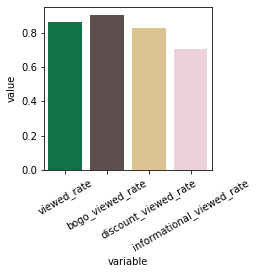

In [196]:
#Analyze Viewed rate

df = plot_data_overall(offer_overall,4, 30, ['viewed_rate','bogo_viewed_rate','discount_viewed_rate','informational_viewed_rate'])

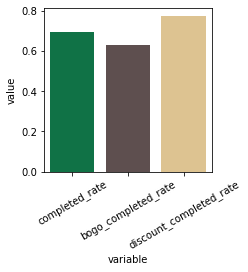

In [195]:
#Analyze Completed rate

df = plot_data_overall(offer_overall,4, 30, ['completed_rate','bogo_completed_rate','discount_completed_rate'])

###### Insights:

**Overall** 86% of the offer recieved are Viewed, and 69% of those viewed are completed. 

**BOGO** with 90% has the **highest View rate**, also **least completeion rate** of 62%

**Disconunt** with 77% has the **highest completion rate**


### Offer Analysis: Overall response to the offer

In [47]:
offer_overall = profile_offer[['customer_id','viewed_count',
 'completed_count',
 'viewed_rate',
 'completed_rate']]

offer_bogo = profile_offer[['customer_id','bogo_viewed_count',
 'bogo_completed_count',
 'bogo_viewed_rate',
 'bogo_completed_rate']]

offer_discount = profile_offer[['customer_id',
 'discount_viewed_count',
 'discount_completed_count',
 'discount_viewed_rate',
 'discount_completed_rate']]

offer_informational = profile_offer[['customer_id','informational_received_count',
 'informational_viewed_count',
 'informational_viewed_rate']]

In [48]:
starbucks = ["#fcfdfe","#869b92","#416753","#2f6144" ,  "#224634", "#006241"]

starbucks_1=  ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
starbucks_d = ["#cce6da", "#66b491", "#008248"]

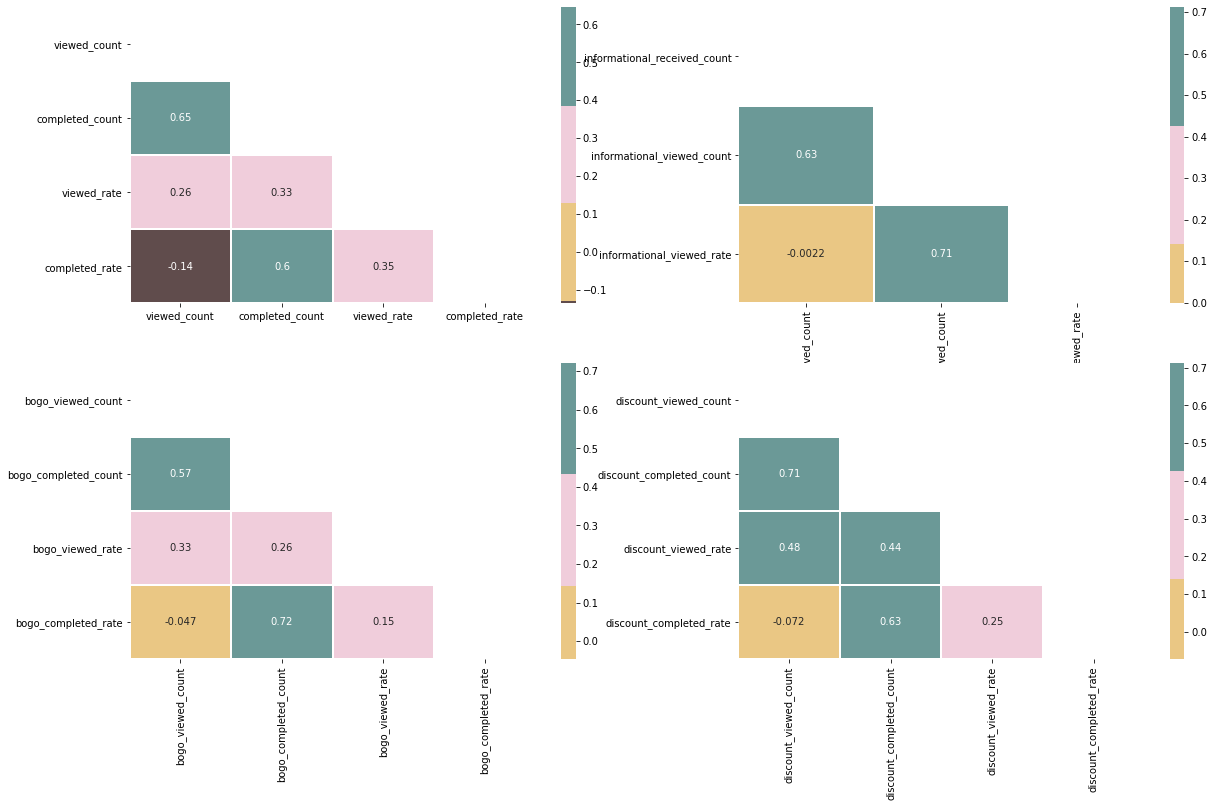

In [49]:
#Correlation plot to analyze how View count, View rate, Completed cont and completed rates are correlated. 

fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(20, 12))


ax = sns.heatmap(offer_overall.corr(), annot=True, mask = np.triu(offer_overall.corr()), linewidths=1, 
                 center=0, cmap = starbucks_1, ax= axs[0,0])


ax = sns.heatmap(offer_informational.corr(), annot=True,  mask = np.triu(offer_informational.corr()),linewidths=1, 
                 center=0, cmap = starbucks_1, ax= axs[0,1])

ax = sns.heatmap(offer_bogo.corr(), annot=True, linewidths=1, mask = np.triu(offer_bogo.corr()), 
                 center=0, cmap = starbucks_1, ax= axs[1,0])


ax = sns.heatmap(offer_discount.corr(), annot=True, linewidths=1, mask = np.triu(offer_discount.corr()), 
                 center=0, cmap = starbucks_1, ax= axs[1,1])

**Analysis**:

Moderate correlation between 
* completed counts and completed rate
* completed count and viewed count

The above correlation are as expected acrss all offer types. No significant pattern here. 

###  Overall Offer performance

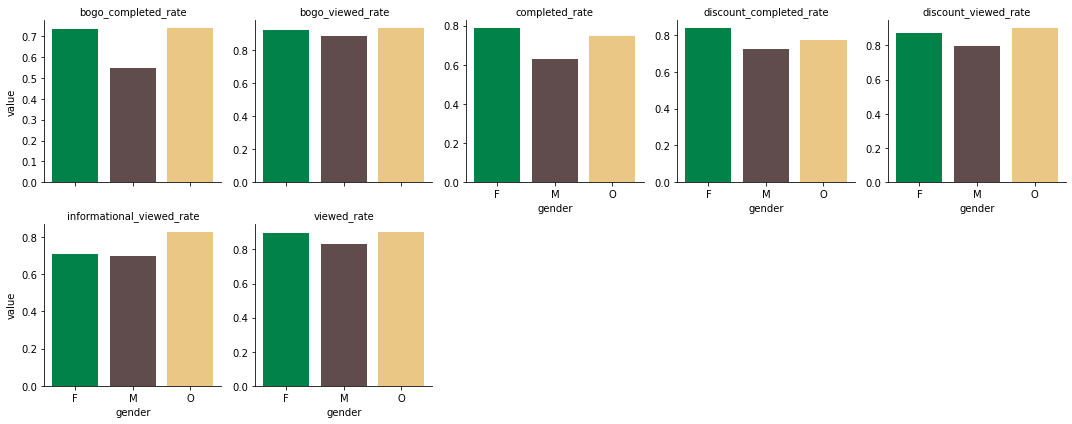

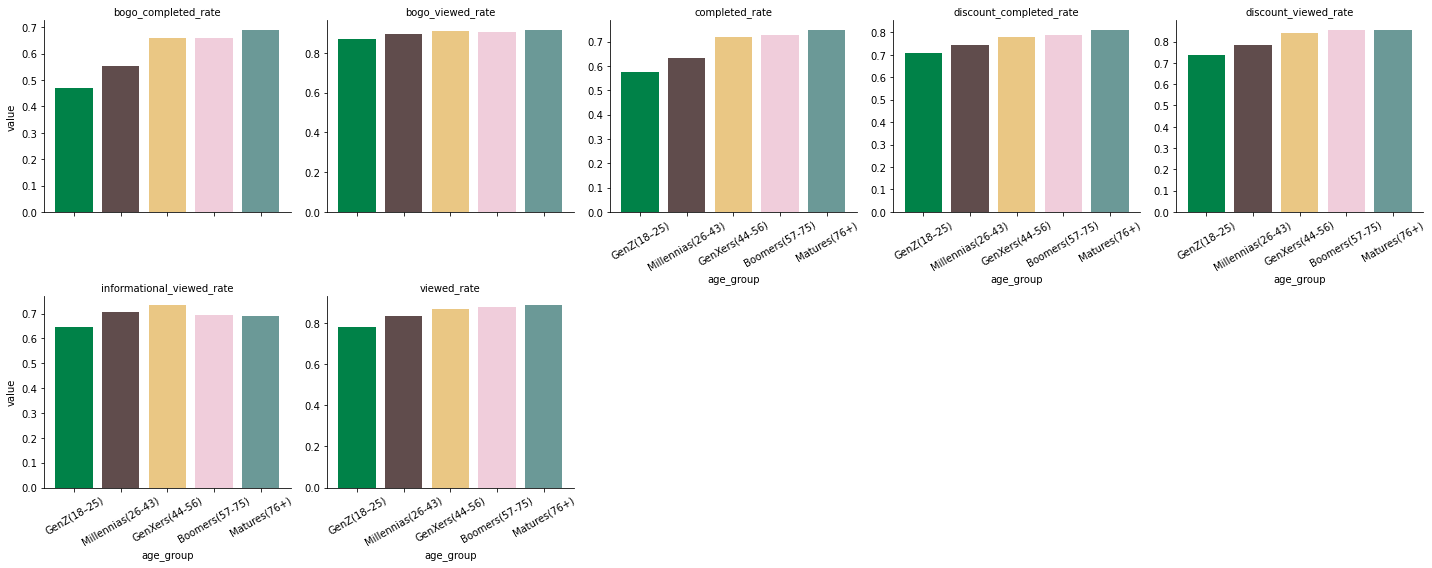

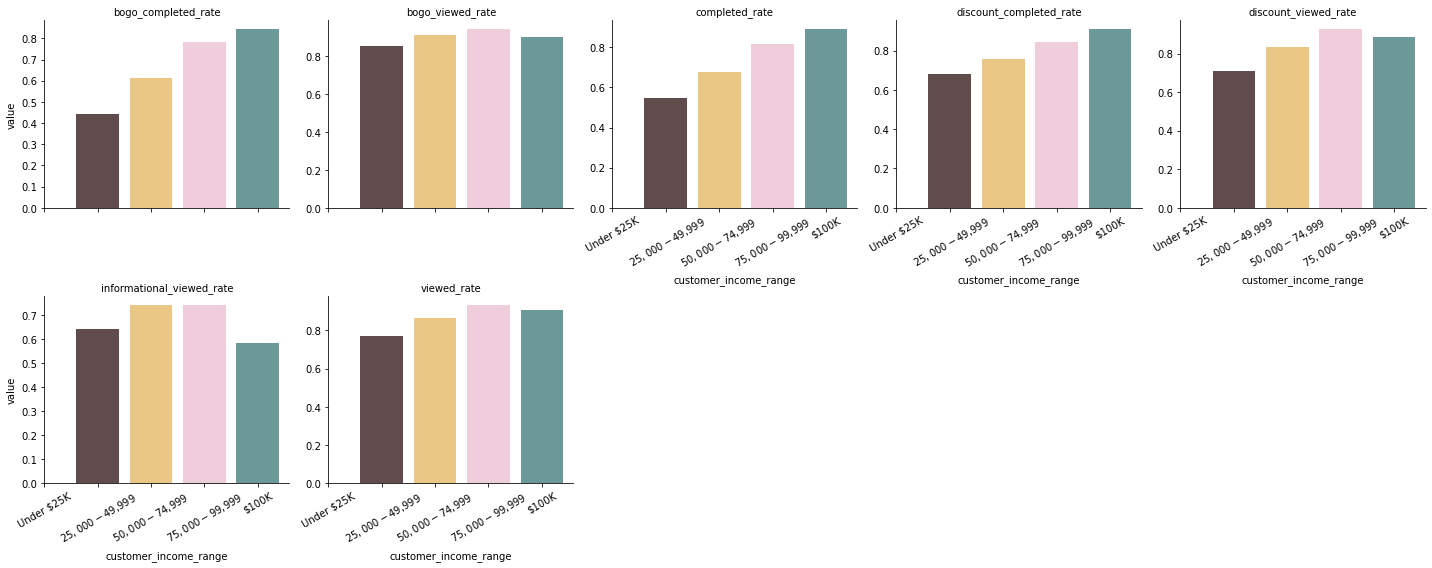

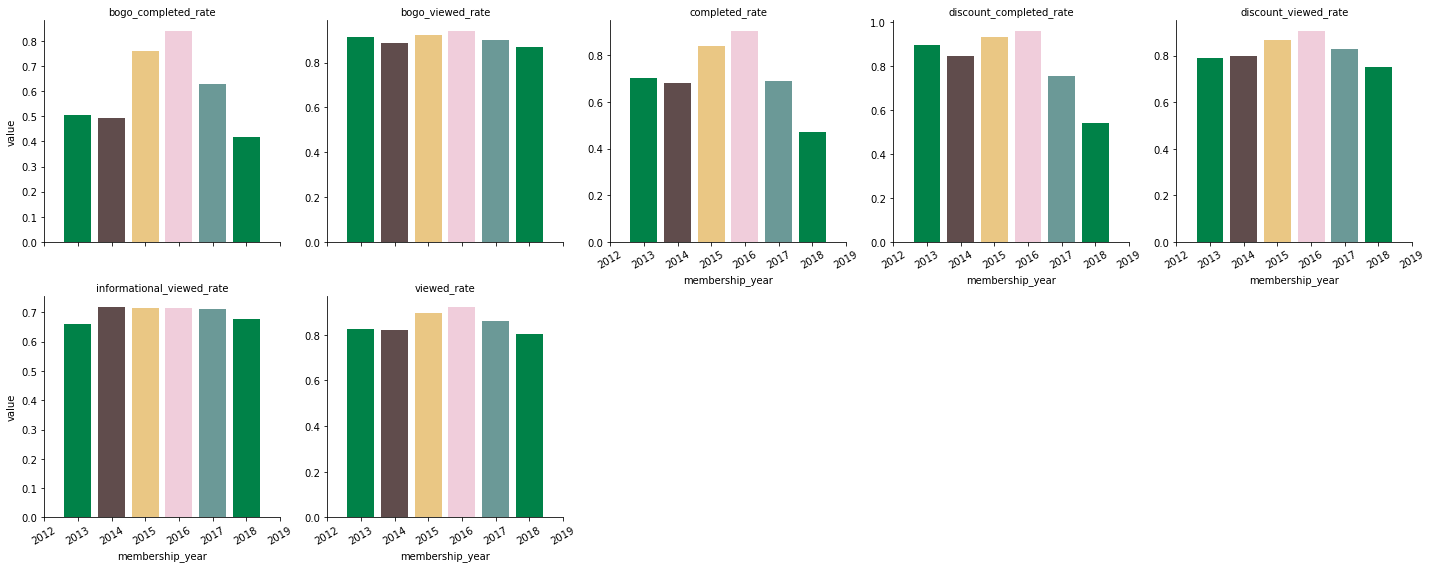

In [200]:
#Plot to visualize average Offers completed, Offers viewed , offer completion rate, offer view rate

df = plot_data(offer_overall,profile_offer,  groupby = 'gender',palette =3,col_wrap=5,height=3,label_rotation =0)

df = plot_data(offer_overall,profile_offer,  groupby = 'age_group',palette =6,col_wrap=5,height=4,label_rotation =30)

df = plot_data(offer_overall,profile_offer,  groupby = 'customer_income_range',palette =5,col_wrap=5,height=4,label_rotation =30)

df = plot_data(offer_overall,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=5,height=4,label_rotation =30)


### 1. BOGO Offer Performance

###### BOGO offers

In [199]:
portfolio_df[portfolio_df['offer_type']=='bogo']

,offer_id,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,offer_1,bogo,10,7,10,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_2,bogo,10,5,10,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_4,bogo,5,7,5,1,1,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,offer_9,bogo,5,5,5,1,1,1,1


In [181]:
offer_bogo_data_viewed = profile_offer[['customer_id','offer_1_viewed_rate',
 'offer_2_viewed_rate','offer_4_viewed_rate','offer_9_viewed_rate']]

offer_bogo_data_comp = profile_offer[['customer_id','completed_rate','offer_1_completed_rate',
 'offer_2_completed_rate','offer_4_completed_rate','offer_9_completed_rate']]

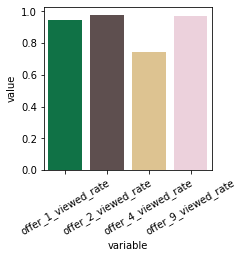

In [184]:
#Analyze Offer completed rate

df = plot_data_overall(offer_bogo_data_viewed , 4, 30, ['offer_1_viewed_rate',
 'offer_2_viewed_rate','offer_4_viewed_rate','offer_9_viewed_rate'])

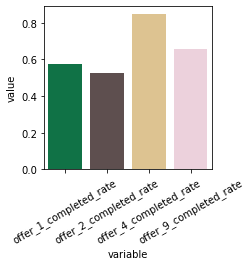

In [183]:
#Analyze Offer Viewed rate

df = plot_data_overall(offer_bogo_data_comp, 4, 30, ['offer_1_completed_rate',
 'offer_2_completed_rate','offer_4_completed_rate','offer_9_completed_rate'])

**Insights**:

Offer 4 with Difficulty 5, duration 7 and reward 5 has the least Viewed rate, also has the highest completion rate.



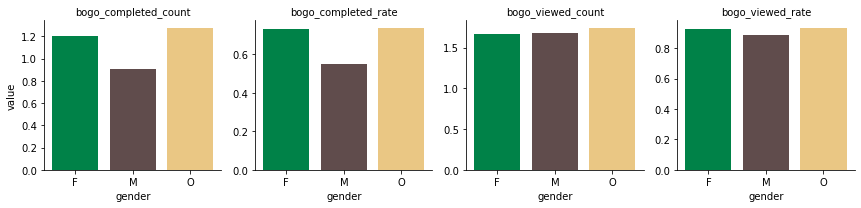

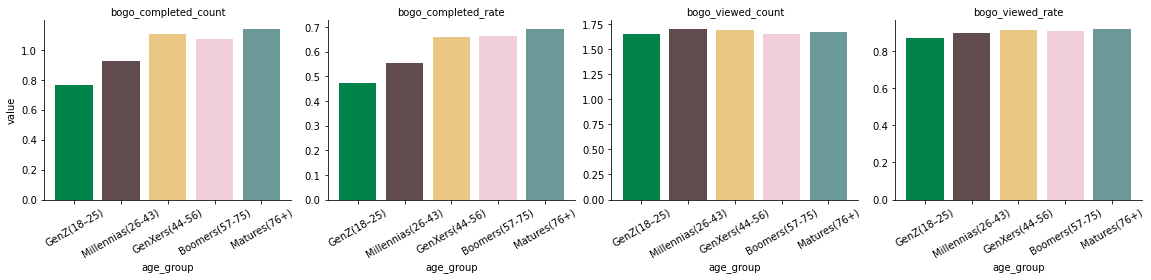

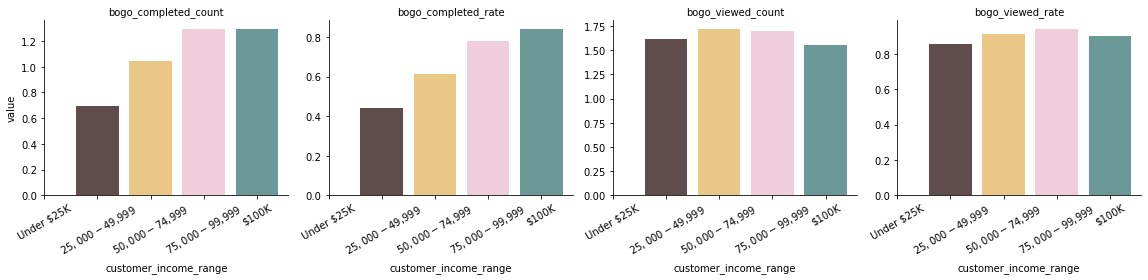

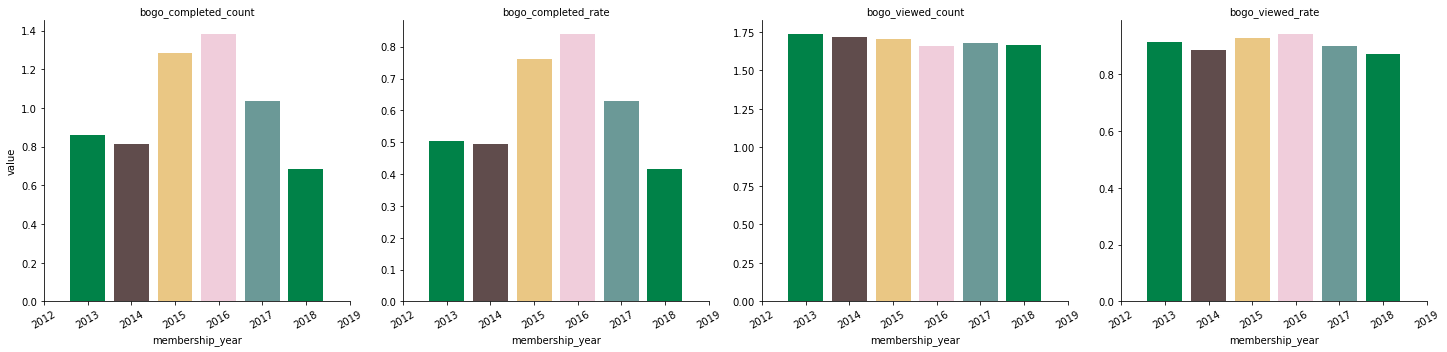

In [185]:
#BOGO: Plot to visualize average Offers completed, Offers viewed , offer completion rate, offer view rate

df = plot_data(offer_bogo,profile_offer,  groupby = 'gender',palette =3,col_wrap=5,height=3,label_rotation =0)

df = plot_data(offer_bogo,profile_offer,  groupby = 'age_group',palette =7,col_wrap=5,height=4,label_rotation =30)

df = plot_data(offer_bogo,profile_offer,  groupby = 'customer_income_range',palette =6,col_wrap=5,height=4,label_rotation =30)

df = plot_data(offer_bogo,profile_offer,  groupby = 'membership_year', palette =6,col_wrap=5,height=5,label_rotation =30)

### 2. Discount Offer Performance

In [239]:
offer_discount = profile_offer[['customer_id','discount_received_count',
 'discount_viewed_count',
 'discount_completed_count',
 'discount_viewed_rate',
 'discount_completed_rate']]


In [135]:

offer_bogo_data_completed = profile_offer[['offer_5_completed_rate',
 'offer_6_completed_rate','offer_7_completed_rate','offer_10_completed_rate']]

offer_bogo_data_viewed = profile_offer[['offer_5_viewed_rate',
 'offer_6_viewed_rate','offer_7_viewed_rate','offer_10_viewed_rate']]

In [ ]:
#Analyze Offer viewed rate

df = plot_data_overall(offer_bogo_data_completed  , 4, 30, ['offer_5_viewed_rate',
 'offer_6_viewed_rate','offer_7_viewed_rate','offer_10_viewed_rate'])

#Analyze Offer completed rate

df = plot_data_overall(offer_bogo_data_completed  , 4, 30, ['offer_5_completed_rate',
 'offer_6_completed_rate','offer_7_completed_rate','offer_10_completed_rate'])

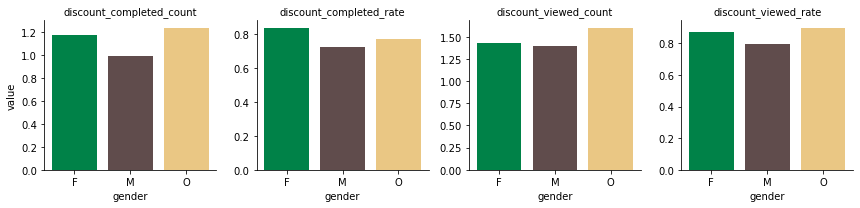

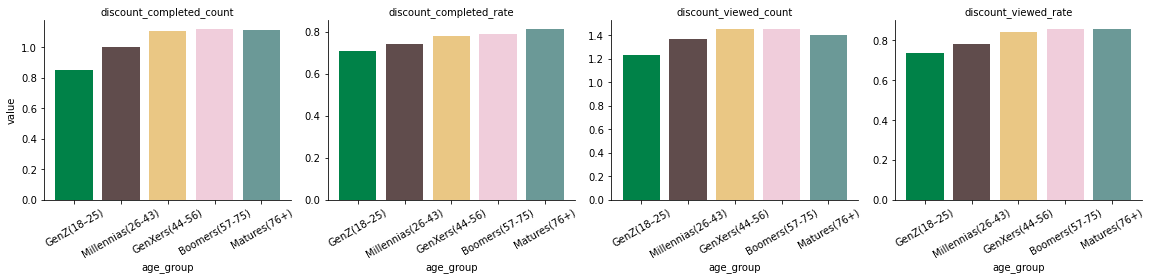

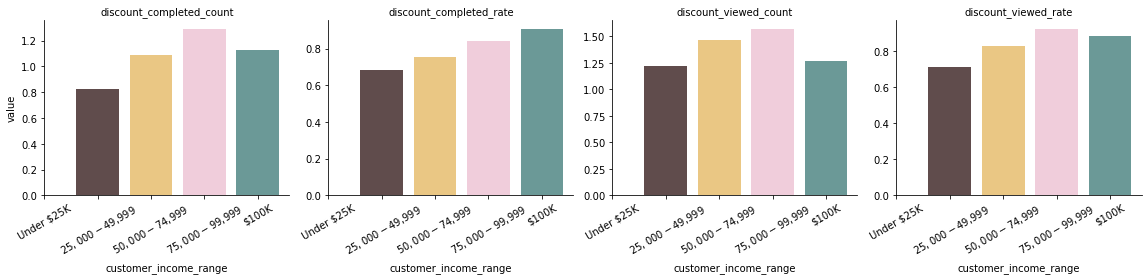

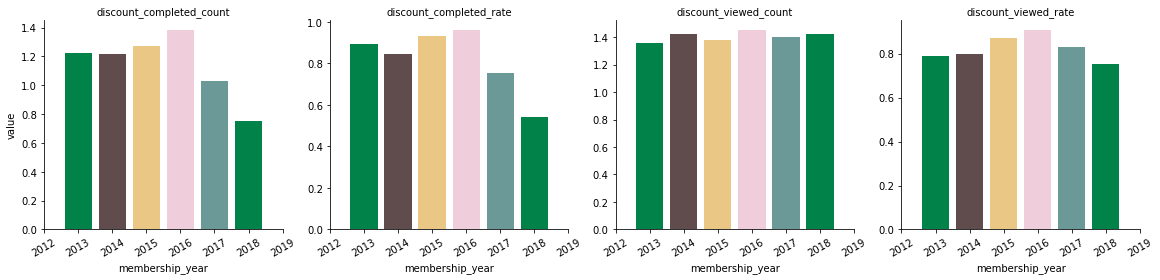

In [201]:
#Discount: Plot to visualize average Offers completed, Offers viewed , offer completion rate, offer view rate

df = plot_data(offer_discount,profile_offer,  groupby = 'gender',palette =3,col_wrap=5,height=3,label_rotation =0)

df = plot_data(offer_discount,profile_offer,  groupby = 'age_group',palette =6,col_wrap=5,height=4,label_rotation =30)

df = plot_data(offer_discount,profile_offer,  groupby = 'customer_income_range',palette =5,col_wrap=5,height=4,label_rotation =30)

df = plot_data(offer_discount,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=5,height=4,label_rotation =30)


## Offer Information

In [62]:
offer_informational = profile_offer[['customer_id', 
 'informational_viewed_count',
 'informational_viewed_rate']]

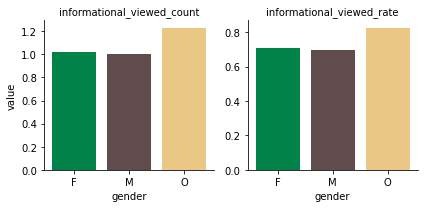

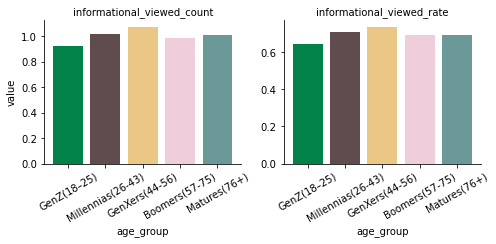

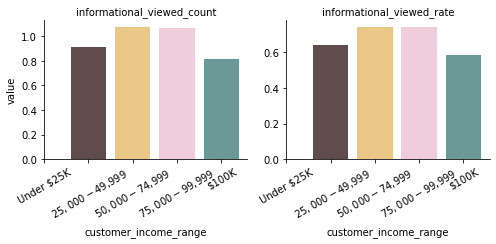

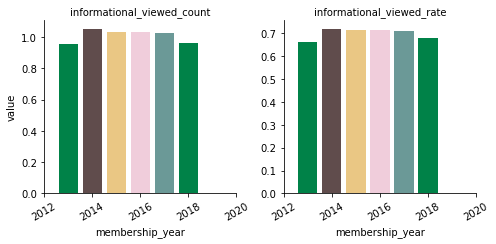

In [202]:
#Informational: Plot to visualize average Offers viewed , offer view rate

df = plot_data(offer_informational ,profile_offer,  groupby = 'gender',palette =3,col_wrap=2,height=3,label_rotation =0)

df = plot_data(offer_informational,profile_offer,  groupby = 'age_group',palette =6,col_wrap=2,height=3.5,label_rotation =30)

df = plot_data(offer_informational,profile_offer,  groupby = 'customer_income_range',palette =5,col_wrap=2,height=3.5,label_rotation =30)

df = plot_data(offer_informational,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=2,height=3.5,label_rotation =30)


## Offer Difficulty

In [76]:
offer_difficulty =  profile_offer[['customer_id',
 'offer_difficulty_5_completed_rate',
 'offer_difficulty_20_completed_rate',
 'offer_difficulty_10_completed_rate',
 'offer_difficulty_7_completed_rate']]

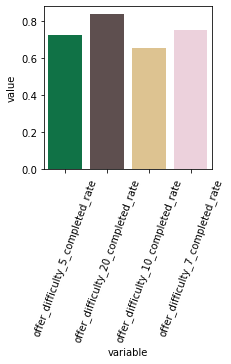

In [127]:
df = plot_data_overall(offer_difficulty, 4, 70, ['offer_difficulty_5_completed_rate',
 'offer_difficulty_20_completed_rate',
 'offer_difficulty_10_completed_rate',
 'offer_difficulty_7_completed_rate'])

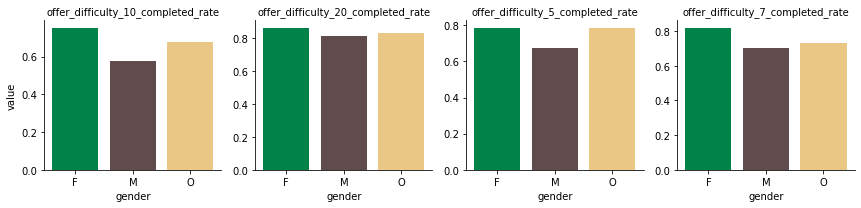

In [125]:
df = plot_data(offer_difficulty  ,profile_offer,  groupby = 'gender',palette =3,col_wrap=5,height=3,label_rotation =0)

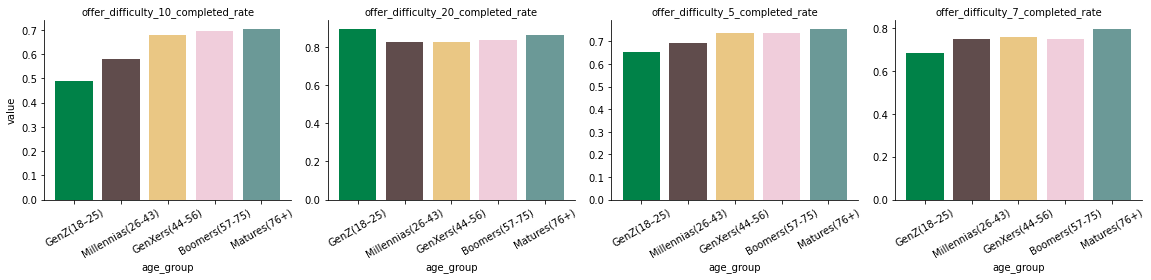

In [78]:
df = plot_data(offer_difficulty ,profile_offer,  groupby = 'age_group',palette =6,col_wrap=5,height=4,label_rotation =30)

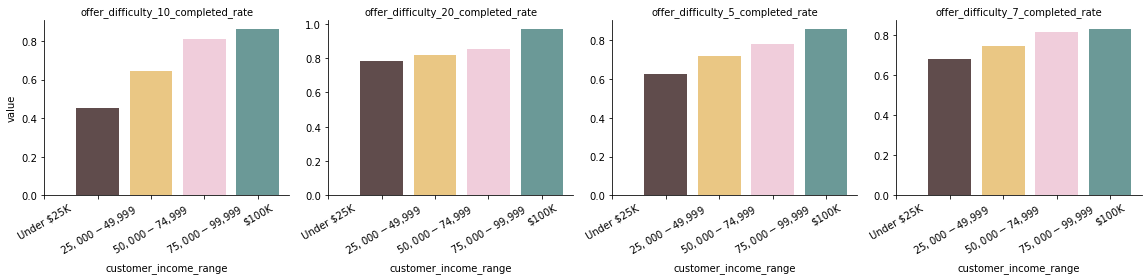

In [80]:
df = plot_data(offer_difficulty ,profile_offer,  groupby = 'customer_income_range',palette =6,col_wrap=5,height=4,label_rotation =30)

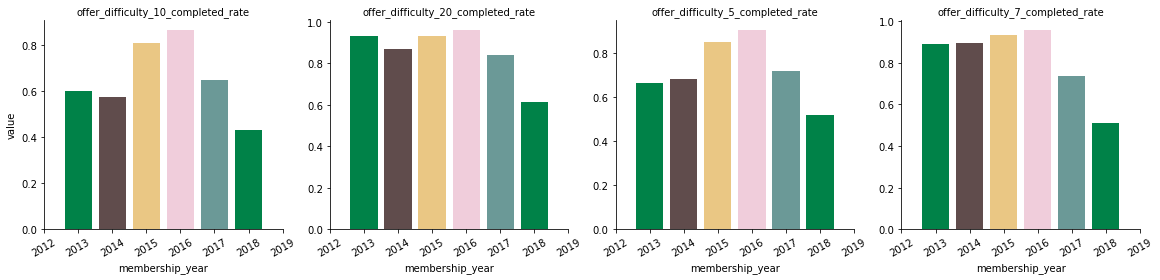

In [81]:
df = plot_data(offer_difficulty ,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=5,height=4,label_rotation =30)

## Offer Duration

In [128]:
#Analyze Offer based on offer Duration:

    
offer_duration =  profile_offer[['customer_id', 'offer_duration_7_viewed_rate',
 'offer_duration_7_completed_rate',
 'offer_duration_10_viewed_rate',
 'offer_duration_10_completed_rate',
 'offer_duration_5_viewed_rate',
 'offer_duration_5_completed_rate']]
    

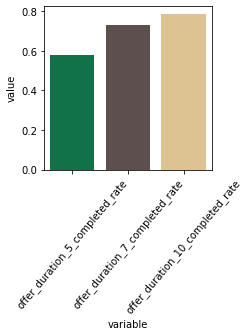

In [131]:
df = plot_data_overall(offer_duration, 4, 50, ['offer_duration_5_completed_rate',
                                               'offer_duration_7_completed_rate',
                                               'offer_duration_10_completed_rate'])

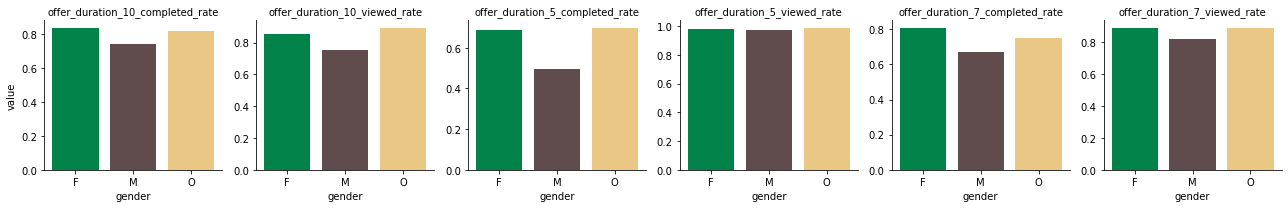

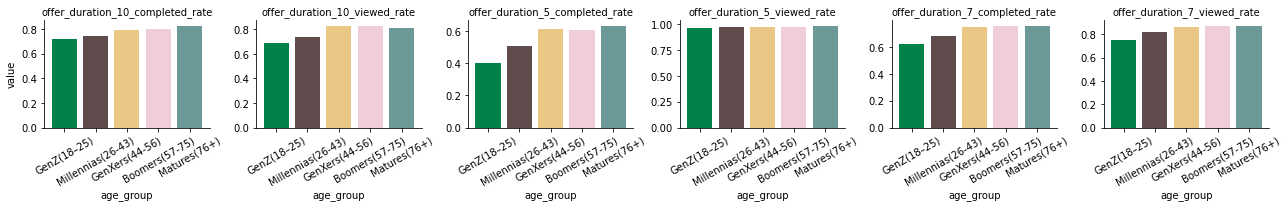

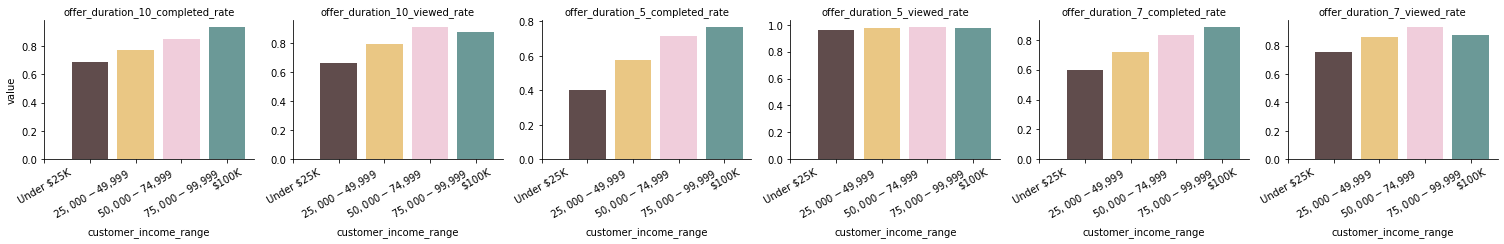

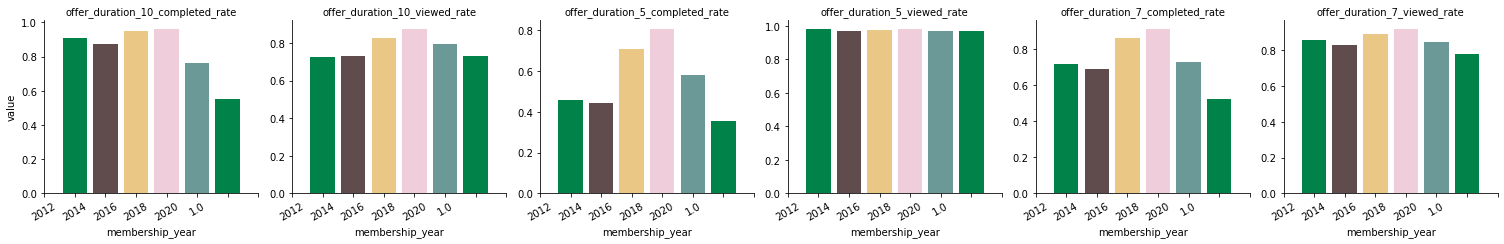

In [146]:
df = plot_data( offer_duration ,profile_offer,  groupby = 'gender',palette =3,col_wrap=6,height=3,label_rotation =0)

df = plot_data( offer_duration,profile_offer,  groupby = 'age_group',palette =6,col_wrap=6,height=3,label_rotation =30)

df = plot_data( offer_duration,profile_offer,  groupby = 'customer_income_range',palette =5,col_wrap=6,height=3.5,label_rotation =30)

df = plot_data( offer_duration,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=6,height=3.5,label_rotation =30)


In [167]:
offer_reward =  profile_offer[['customer_id', 
 'offer_reward_2_viewed_rate',
 'offer_reward_2_completed_rate',
 'offer_reward_3_viewed_rate',
 'offer_reward_3_completed_rate',
 'offer_reward_5_viewed_rate',
 'offer_reward_5_completed_rate',
 'offer_reward_10_viewed_rate',
 'offer_reward_10_completed_rate']]

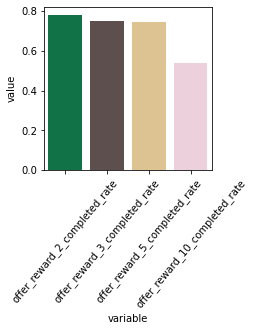

In [168]:
df = plot_data_overall(offer_reward, 5, 50, ['offer_reward_2_completed_rate',
                                               'offer_reward_3_completed_rate',
                                               'offer_reward_5_completed_rate',
                                            'offer_reward_10_completed_rate'])

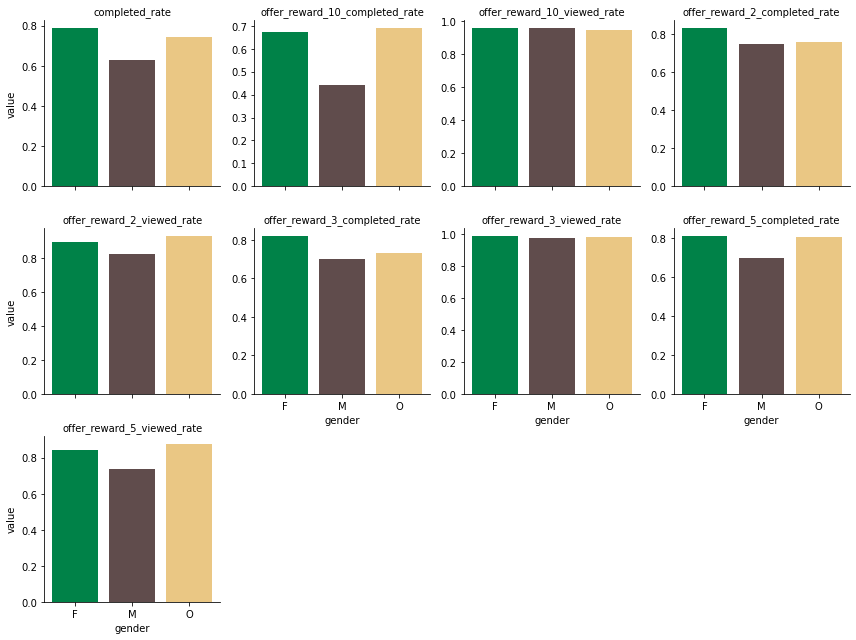

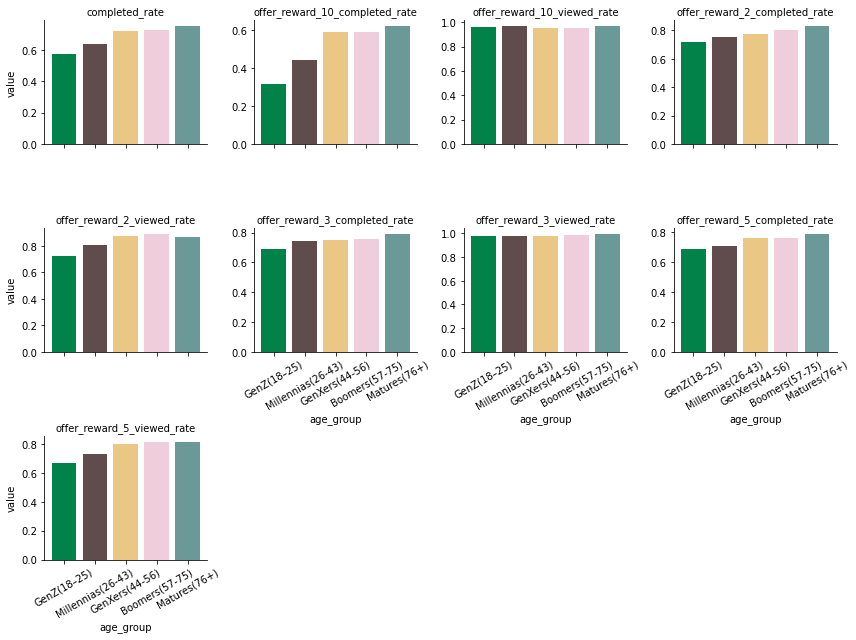

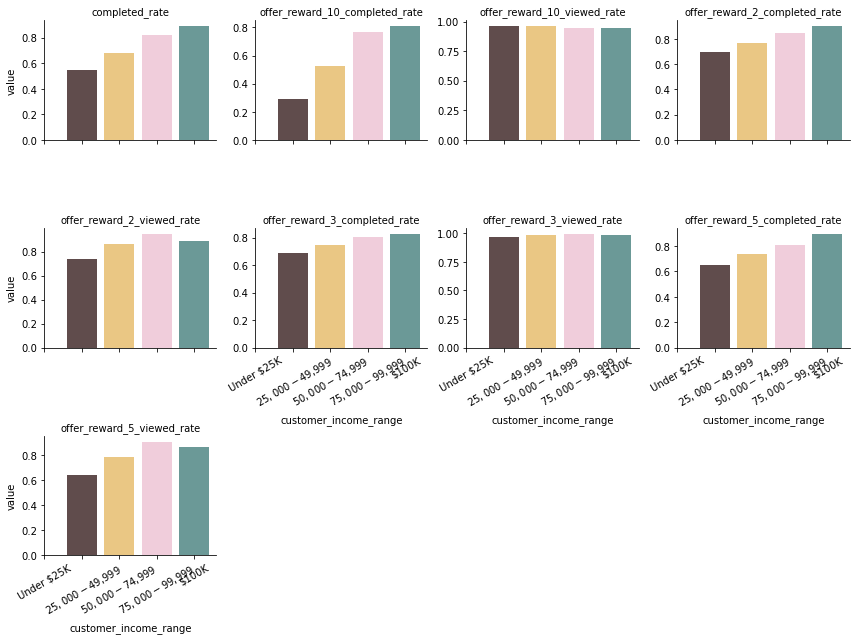

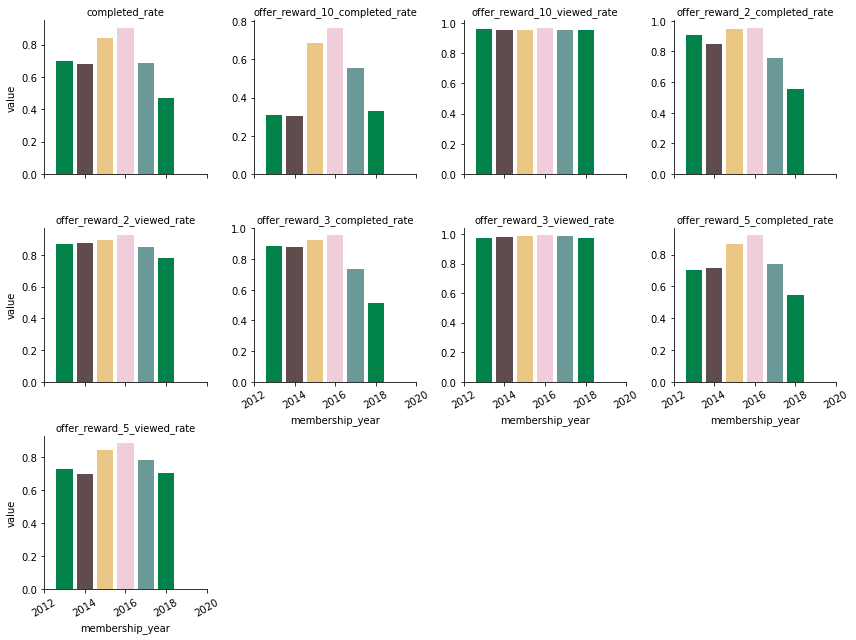

In [166]:
df = plot_data(offer_reward ,profile_offer,  groupby = 'gender',palette =4,col_wrap=4,height=3,label_rotation =0)
df = plot_data( offer_reward,profile_offer,  groupby = 'age_group',palette =6,col_wrap=4,height=3,label_rotation =30)
df = plot_data( offer_reward,profile_offer,  groupby = 'customer_income_range',palette =6,col_wrap=4,height=3,label_rotation =30)
df = plot_data( offer_reward,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=4,height=3,label_rotation =30)

## Channels Analysis

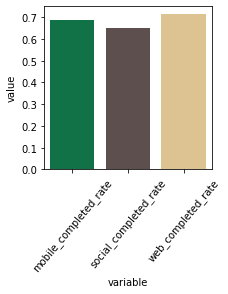

In [169]:
 channel_completed =  profile_offer[['customer_id', 
                     
 'mobile_completed_rate',
 'social_completed_rate',
 'web_completed_rate',
 'completed_rate' ,                        
 'mobile_viewed_rate',
 'social_viewed_rate',
 'web_viewed_rate'
]]

df = plot_data_overall( channel, 4, 50, [ 'mobile_completed_rate','social_completed_rate','web_completed_rate'])

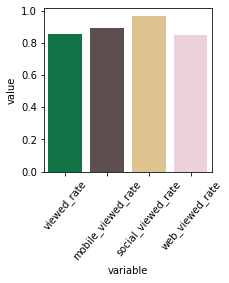

In [170]:
channel_viewed =  profile_offer[['customer_id', 
  'viewed_rate' ,                        
 'mobile_viewed_rate',
 'social_viewed_rate',
 'web_viewed_rate'
]]

df = plot_data_overall( channel_viewed , 4, 50, ['viewed_rate'  ,'mobile_viewed_rate','social_viewed_rate','web_viewed_rate'])

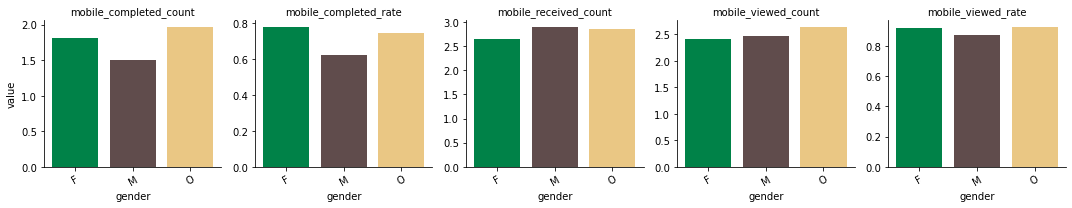

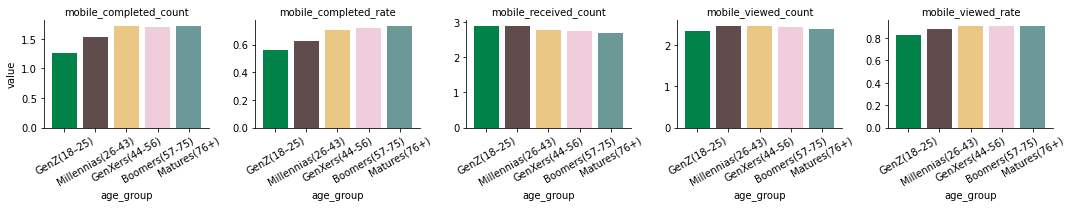

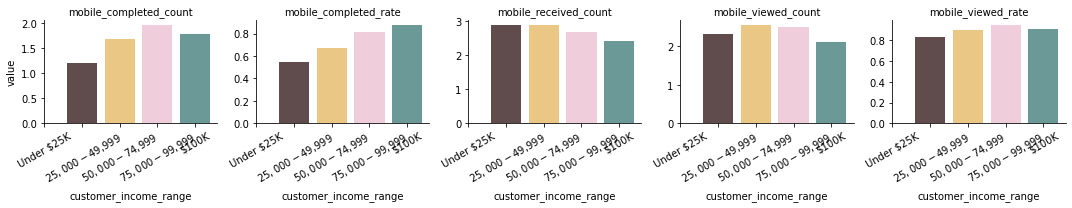

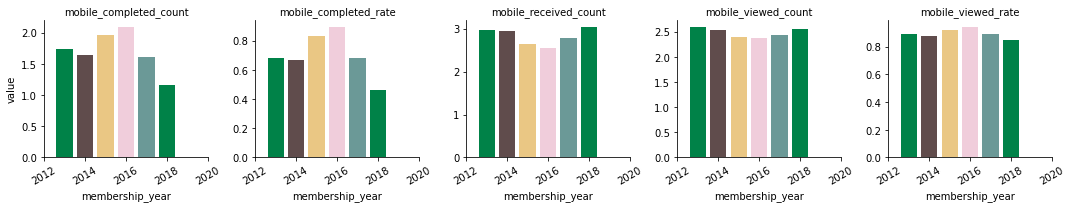

In [107]:
#Analyze offers recieved through Channel - Mobile

 offer_mobile =  profile_offer[['customer_id',  
 'mobile_received_count',
 'mobile_viewed_count',
 'mobile_completed_count',
 'mobile_viewed_rate',
 'mobile_completed_rate',
]]
    
    
df = plot_data(offer_mobile ,profile_offer,  groupby = 'gender',palette =4,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_mobile,profile_offer,  groupby = 'age_group',palette =6,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_mobile,profile_offer,  groupby = 'customer_income_range',palette =6,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_mobile,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=5,height=3,label_rotation =30)


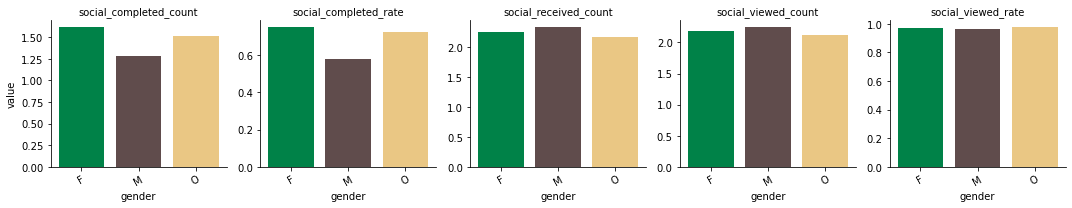

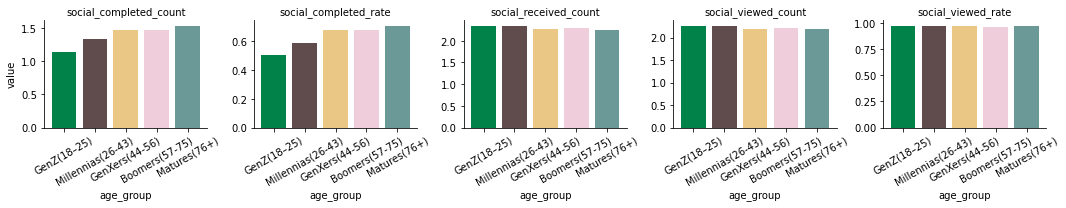

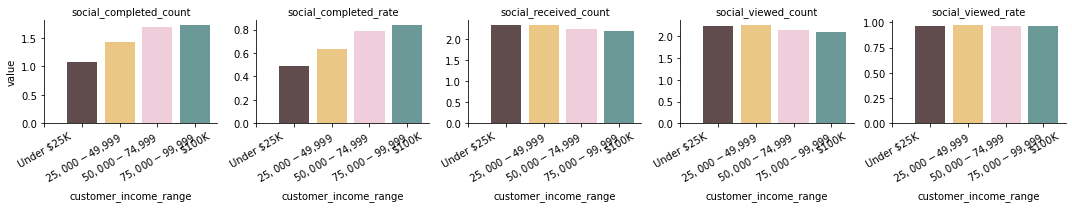

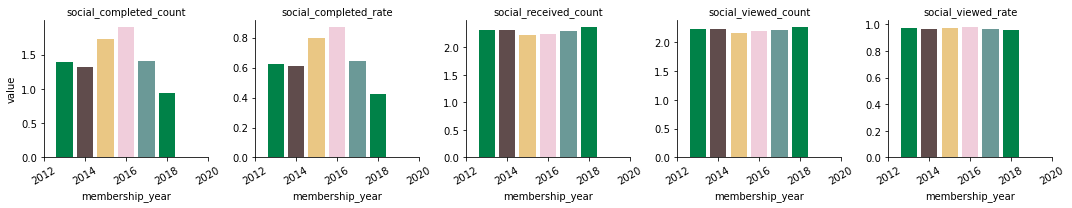

In [109]:
#Analyze offers recieved through Channel - Social media

 offer_social =  profile_offer[['customer_id',  
 'social_received_count',
 'social_viewed_count',
 'social_completed_count',
 'social_viewed_rate',
 'social_completed_rate']]


df = plot_data(offer_social ,profile_offer,  groupby = 'gender',palette =4,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_social,profile_offer,  groupby = 'age_group',palette =6,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_social,profile_offer,  groupby = 'customer_income_range',palette =6,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_social,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=5,height=3,label_rotation =30)


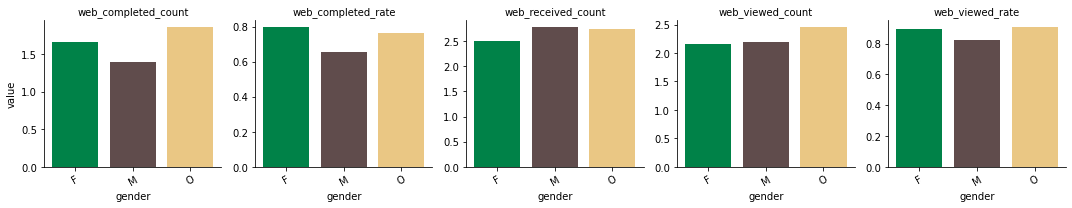

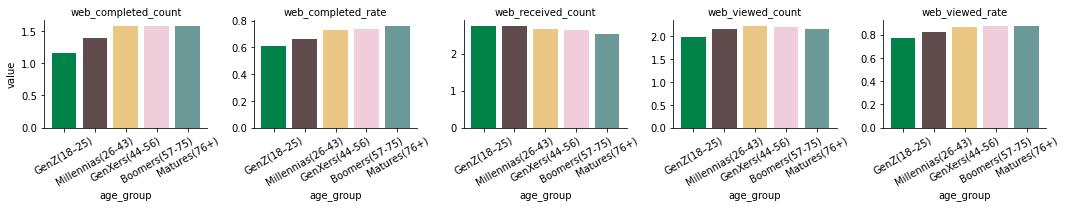

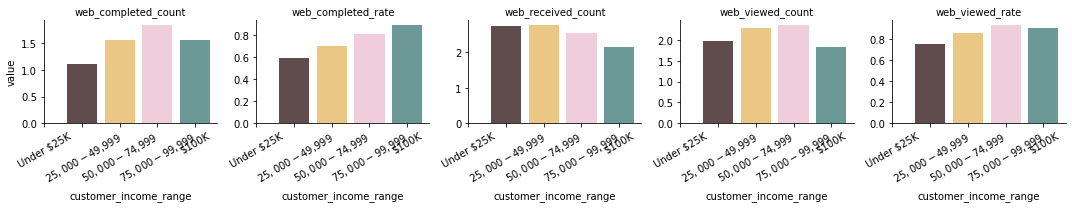

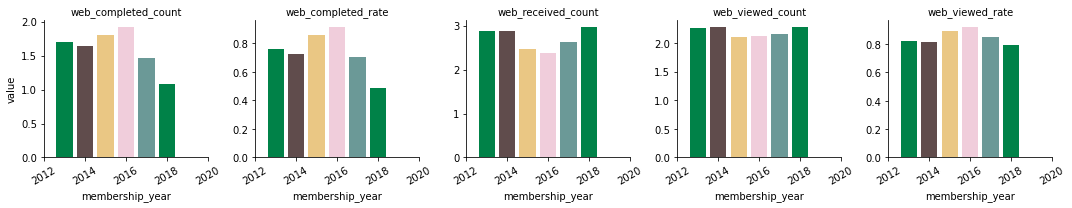

In [111]:
#Analyze offers recieved through Channel - Social Web

 offer_web =  profile_offer[['customer_id',  
 'web_received_count',
 'web_viewed_count',
 'web_completed_count',
 'web_viewed_rate',
 'web_completed_rate']]


df = plot_data(offer_web ,profile_offer,  groupby = 'gender',palette =4,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_web,profile_offer,  groupby = 'age_group',palette =6,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_web,profile_offer,  groupby = 'customer_income_range',palette =6,col_wrap=5,height=3,label_rotation =30)
df = plot_data( offer_web,profile_offer,  groupby = 'membership_year',palette =6,col_wrap=5,height=3,label_rotation =30)


### Customer Segmentation: Create new features based on RFM analysis.

### RFM Analysis

In this section we are going to perform Recency Frequency Monetary value analysis of the customer. 

RFM Analysis is a very commonly used method in marketing analytics to segments customers into homogeneous groups. The three variables used for RFM analysis are:

* **Recency**: When did the customer make the last purchase?

* **Frequency**: How frequently does the customer make a purchase?

* **Monetary**: How much has the customer spent?

These values can be collected from the customer's transaction data based on information like Date of purchase, money spent for each transactions.

In [21]:
df = plot_data(offer_bogo,profile_offer,  groupby = 'rfm_segment',palette =4,col_wrap=5,height=5,label_rotation =30)
df = plot_data( offer_duration,profile_offer,  groupby = 'rfm_segment',palette =4,col_wrap=4,height=3,label_rotation =30)
df = plot_data(offer_informational,profile_offer,  groupby = 'rfm_segment',palette =4,col_wrap=5,height=3,label_rotation =30)
df = plot_data(offer_discount,profile_offer,  groupby = 'rfm_segment',palette =4,col_wrap=5,height=4,label_rotation =30)

NameError: name 'plot_data' is not defined